In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [3]:
import json
from pathlib import Path
from typing import Tuple

import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.preprocessing import StandardScaler

try:  # Parquet is faster but optional on Kaggle
    import pyarrow.parquet as pq  # type: ignore
except ModuleNotFoundError:
    pq = None  # type: ignore

DATA_DIR = Path("/kaggle/input/ieee-fraud-detection")  # adjust if local
RAND      = 42
VAL_FRAC  = 0.10            # 10 % chronological validation slice
ALERT_Q   = 0.003           # raise top 0.3 % validation rows as alerts

In [4]:
# ---------------------------------------------------------------------------
# 1  Pre‑processing helpers
# ---------------------------------------------------------------------------

def _read_file(fp: Path) -> pd.DataFrame:
    if fp.suffix == ".parquet" and pq is not None:
        df = pq.read_table(fp).to_pandas()
        df.columns = [c.replace("id-", "id_") if c.startswith("id-") else c for c in df.columns]
        return df
        
    df = pd.read_csv(fp)
    if any(c.startswith("id-") for c in df.columns):
        df.columns = [c.replace("id-", "id_") if c.startswith("id-") else c for c in df.columns]
    return df



def load_raw(data_dir: Path = DATA_DIR) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Load train & test transaction tables (plus identity if present)."""
    train_fp = next(data_dir.glob("train_transaction.*"))
    test_fp  = next(data_dir.glob("test_transaction.*"))

    train = _read_file(train_fp)
    test  = _read_file(test_fp)

    id_train_fp = data_dir / f"train_identity{train_fp.suffix}"
    if id_train_fp.exists():
        train_id = _read_file(id_train_fp)
        test_id  = _read_file(data_dir / f"test_identity{train_fp.suffix}")
        train = train.merge(train_id, on="TransactionID", how="left")
        test  = test.merge(test_id,  on="TransactionID", how="left")
    return train, test


def basic_clean(train: pd.DataFrame, test: pd.DataFrame):
    """String‑cast categoricals, rare‑label bucket, fill NaNs.
    Also normalises any identity column prefixes in the *test* set from
    `id-xx` → `id_xx` so schemas stay aligned.
    """

        # 1. Cast categoricals to string ----------------------------------------
    cat_cols = [c for c in train.columns if train[c].dtype == "object"]
    for c in cat_cols:
        train[c] = train[c].astype("string")
        if c in test.columns:               # some id_* cols appear only in train
            test[c] = test[c].astype("string")

    # Recompute cat cols present in *both* sets for downstream ops
    cat_common = [c for c in cat_cols if c in test.columns]

    # 2. Rare‑label grouping -------------------------------------------------
    for c in cat_cols:
        rare_vals = train[c].value_counts(dropna=False)
        rare_vals = rare_vals[rare_vals < 10].index
        train[c] = train[c].replace(rare_vals, "__RARE__")
        if c in test.columns:
            test[c] = test[c].replace(rare_vals, "__RARE__")

    # 3. Fill missing --------------------------------------------------------
    train[cat_cols] = train[cat_cols].fillna("__NA__")
    test[cat_common] = test[cat_common].fillna("__NA__")

    num_cols = [c for c in train.columns if c not in cat_cols + ["isFraud"]] 
    for c in cat_cols:
        rare_vals = train[c].value_counts(dropna=False)
        rare_vals = rare_vals[rare_vals < 10].index
        train[c] = train[c].replace(rare_vals, "__RARE__")
        test[c]  = test[c].replace(rare_vals, "__RARE__")

    # 3. Fill missing --------------------------------------------------------
    train[cat_cols] = train[cat_cols].fillna("__NA__")
    test[cat_cols]  = test[cat_cols].fillna("__NA__")

    num_cols = [c for c in train.columns if c not in cat_cols + ["isFraud"]]
    train[num_cols] = train[num_cols].fillna(-999.0)
    test[num_cols]  = test[num_cols].fillna(-999.0)

    # 4. Harmonise id‑column prefix in *test* -------------------------------
    if any(col.startswith("id-") for col in test.columns):
        test.columns = [
            col.replace("id-", "id_") if col.startswith("id-") else col
            for col in test.columns
        ]

    return train, test


def time_val_split(df: pd.DataFrame, frac: float = VAL_FRAC):
    """Chronological validation split using TransactionDT."""
    cutoff = df["TransactionDT"].quantile(1 - frac)
    return df[df["TransactionDT"] < cutoff].copy(), df[df["TransactionDT"] >= cutoff].copy()



In [6]:
# ---------------------------------------------------------------------------
# 2  Feature engineering for Isolation Forest
# ---------------------------------------------------------------------------

def build_feature_matrices(train: pd.DataFrame, valid: pd.DataFrame, test: pd.DataFrame):
    cat_cols = [c for c in train.columns if train[c].dtype == "string"]
    num_cols = [c for c in train.columns if c not in cat_cols + ["isFraud"]]

    # Frequency‑encode categoricals (training stats only)
    def _encode(series: pd.Series, mapping: pd.Series):
        return series.map(mapping).fillna(0.0).to_numpy(dtype="float32")[:, None]

    tr_blocks, va_blocks, te_blocks = [], [], []
    for c in cat_cols:
        freq_map = train[c].value_counts(dropna=False, normalize=True)
        tr_blocks.append(_encode(train[c], freq_map))
        va_blocks.append(_encode(valid[c], freq_map))
        te_blocks.append(_encode(test[c],  freq_map))

    # Numeric: z‑score
    scaler   = StandardScaler().fit(train[num_cols])
    tr_num   = scaler.transform(train[num_cols]).astype("float32")
    va_num   = scaler.transform(valid[num_cols]).astype("float32")
    te_num   = scaler.transform(test[num_cols]).astype("float32")

    X_tr = np.hstack(tr_blocks + [tr_num])
    X_va = np.hstack(va_blocks + [va_num])
    X_te = np.hstack(te_blocks + [te_num])
    return X_tr, X_va, X_te


In [10]:
# ---------------------------------------------------------------------------
# 3  Main routine
# ---------------------------------------------------------------------------

def main():
    print("[INFO] Loading raw data …")
    train_raw, test_raw = load_raw()
    train_raw, test_raw = basic_clean(train_raw, test_raw)

    # Some public dumps label identity columns with "id-" only in test → fix
    if any(c.startswith("id-") for c in test_raw.columns):
        test_raw.columns = [c.replace("id-", "id_") if c.startswith("id-") else c for c in test_raw.columns]

    train_df, valid_df = time_val_split(train_raw)

    X_tr, X_va, X_te = build_feature_matrices(train_df, valid_df, test_raw)
    y_va             = valid_df["isFraud"].astype(int).values
    txid_te          = test_raw["TransactionID"].values

    print("[INFO] Fitting Isolation Forest …")
    iso = IsolationForest(
        n_estimators=400,
        max_samples=2048,
        contamination="auto",
        random_state=RAND,
        n_jobs=-1,
    )
    iso.fit(np.vstack([X_tr, X_te]))  # unsupervised – include test rows
    joblib.dump(iso, "iso_forest.joblib")

    # Validation scoring
    va_score = -iso.decision_function(X_va)  # higher = more anomalous
    thr      = np.quantile(va_score, 1 - ALERT_Q)
    va_pred  = (va_score >= thr).astype(int)

    metrics = {
        "accuracy" : accuracy_score(y_va, va_pred),
        "precision": precision_score(y_va, va_pred, zero_division=0),
        "recall"   : recall_score(y_va, va_pred, zero_division=0),
        "f1"       : f1_score(y_va, va_pred, zero_division=0),
        "roc_auc"  : roc_auc_score(y_va, va_score),
        "pr_auc"   : average_precision_score(y_va, va_score),
        "threshold": float(thr),
    }
    print("[Isolation Forest] " + "  ".join(f"{k}={v:.4f}" for k, v in metrics.items()))
    with open("iso_metrics.json", "w") as fp:
        json.dump(metrics, fp, indent=2)

    # Kaggle submission
    te_score = -iso.decision_function(X_te)
    prob = (te_score - te_score.min()) / (te_score.max() - te_score.min() + 1e-9)
    pd.DataFrame({"TransactionID": txid_te, "isFraud": prob}).to_csv("iso_submission.csv", index=False)
    print("[INFO] Wrote iso_submission.csv – ready to upload to Kaggle!")


if __name__ == "__main__":
    main()


[INFO] Loading raw data …
[INFO] Fitting Isolation Forest …
[Isolation Forest] accuracy=0.9595  precision=0.0000  recall=0.0000  f1=0.0000  roc_auc=0.7468  pr_auc=0.0850  threshold=0.2529
[INFO] Wrote iso_submission.csv – ready to upload to Kaggle!


| What happened?                  | Why the number looks like that                                                                                                                                        |
| ------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Accuracy ≈ 96 %**             | Class 0 (“not fraud”) dominates the data, so even predicting *nothing* as fraud looks “accurate”.                                                                     |
| **Precision = Recall = F1 = 0** | With the alert quota you chose (`ALERT_Q = 0.003`, i.e. top 0.3 % of scores) **none of those rows happened to be labelled fraud** in the validation slice, so TP = 0. |
| **ROC-AUC = 0.75**              | ROC-AUC ignores any threshold; it measures how well the raw anomaly **scores** separate fraud vs. non-fraud. 0.75 means “better than random”.                         |
| **PR-AUC = 0.085**              | On highly-imbalanced data PR-AUC is stricter. 0.085 is modest but again > random (which would equal the fraud prevalence).                                            |
| **`threshold = 0.2529`**        | That’s the *score* at the 99.7-percentile (1 − 0.003) of validation scores. You converted scores to labels with `score ≥ threshold`.                                  |


In [21]:
gc.collect()

97


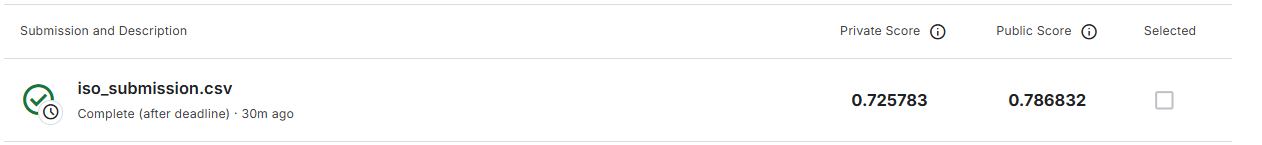
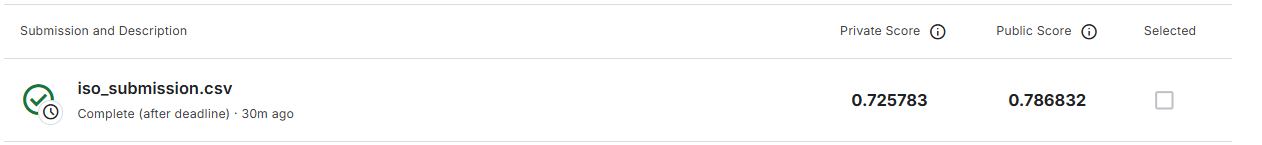
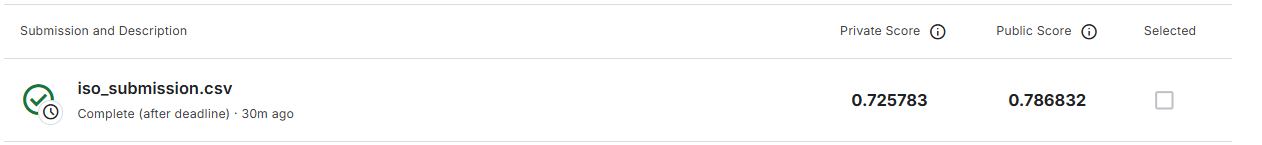
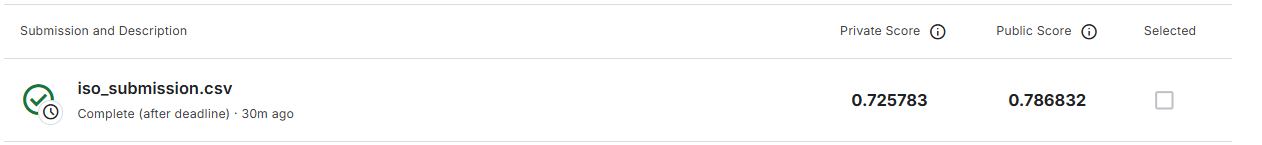

In [1]:
# Imports & config -----------------------------------------------------------
from pathlib import Path
from typing import Callable, Tuple
import json, os, joblib, numpy as np, pandas as pd, shap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (accuracy_score, average_precision_score, f1_score,
                             precision_score, recall_score, roc_auc_score)
from tensorflow import keras
from tensorflow.keras import layers
try:
    import pyarrow.parquet as pq  # optional speed‑up
except ModuleNotFoundError:
    pq = None

DATA_DIR = Path("/kaggle/input/ieee-fraud-detection")
RAND      = 42
VAL_FRAC  = 0.10
ALERT_Q   = 0.003
ARTIFACTS = Path("./artefacts").resolve(); ARTIFACTS.mkdir(exist_ok=True, parents=True)

2025-07-06 02:58:29.678792: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751770709.917342      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751770709.988642      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Data loading & basic cleaning helpers -------------------------------------

def _read(fp: Path) -> pd.DataFrame:
    """Read CSV or Parquet and normalise any `id-xx` columns to `id_xx`."""
    if fp.suffix == ".parquet" and pq is not None:
        df = pq.read_table(fp).to_pandas()
        df.columns = [c.replace("id-", "id_") if c.startswith("id-") else c for c in df.columns]
        return df

    df = pd.read_csv(fp)
    if any(c.startswith("id-") for c in df.columns):
        df.columns = [c.replace("id-", "id_") if c.startswith("id-") else c for c in df.columns]
    return df

def load_raw() -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_fp = next(DATA_DIR.glob("train_transaction.*"))
    test_fp  = next(DATA_DIR.glob("test_transaction.*"))
    train, test = _read(train_fp), _read(test_fp)
    id_train_fp = DATA_DIR / f"train_identity{train_fp.suffix}"
    if id_train_fp.exists():
        train_id = _read(id_train_fp)
        test_id  = _read(DATA_DIR / f"test_identity{train_fp.suffix}")
        train = train.merge(train_id, on="TransactionID", how="left")
        test  = test.merge(test_id,  on="TransactionID", how="left")
    return train, test


def clean(train: pd.DataFrame, test: pd.DataFrame):
    cat_cols = [c for c in train.columns if train[c].dtype == "object"]
    for c in cat_cols:
        train[c] = train[c].astype("string")
        if c in test.columns:
            test[c] = test[c].astype("string")

    for c in cat_cols:
        rare = train[c].value_counts(dropna=False)
        rare = rare[rare < 10].index
        train[c] = train[c].replace(rare, "__RARE__")
        if c in test.columns:
            test[c] = test[c].replace(rare, "__RARE__")

    train[cat_cols] = train[cat_cols].fillna("__NA__")
    common_cat = [c for c in cat_cols if c in test.columns]
    test[common_cat] = test[common_cat].fillna("__NA__")

    num_cols = [c for c in train.columns if c not in cat_cols + ["isFraud"]]
    train[num_cols] = train[num_cols].fillna(-999.0)
    test[num_cols]  = test[num_cols].fillna(-999.0)

    if any(col.startswith("id-") for col in test.columns):
        test.columns = [col.replace("id-", "id_") if col.startswith("id-") else col for col in test.columns]

    return cat_cols, num_cols


def time_val_split(df: pd.DataFrame):
    cutoff = df["TransactionDT"].quantile(1 - VAL_FRAC)
    return df[df["TransactionDT"] < cutoff].copy(), df[df["TransactionDT"] >= cutoff].copy()


In [3]:
# Feature‑matrix builder -----------------------------------------------------

def build_matrix(train, valid, test, cat_cols, num_cols):
    tr_cat, va_cat, te_cat = [], [], []
    for c in cat_cols:
        freq = train[c].value_counts(dropna=False, normalize=True)
        enc = lambda s: s.map(freq).fillna(0.).to_numpy("float32")[:, None]
        tr_cat.append(enc(train[c])); va_cat.append(enc(valid[c])); te_cat.append(enc(test[c]))
    scaler = StandardScaler().fit(train[num_cols])
    tr_num = scaler.transform(train[num_cols]).astype("float32")
    va_num = scaler.transform(valid[num_cols]).astype("float32")
    te_num = scaler.transform(test[num_cols]).astype("float32")
    return np.hstack(tr_cat + [tr_num]), np.hstack(va_cat + [va_num]), np.hstack(te_cat + [te_num])

In [4]:
# %%
# Evaluation helper ----------------------------------------------------------

def evaluate(name: str, score_fn: Callable[[np.ndarray], np.ndarray], X_va, y_va, X_te, txid):
    va_score = score_fn(X_va)
    thr = np.quantile(va_score, 1 - ALERT_Q)
    va_pred = (va_score >= thr).astype(int)
    metrics = dict(
        accuracy = accuracy_score(y_va, va_pred),
        precision= precision_score(y_va, va_pred, zero_division=0),
        recall   = recall_score(y_va, va_pred, zero_division=0),
        f1       = f1_score(y_va, va_pred, zero_division=0),
        roc_auc  = roc_auc_score(y_va, va_score),
        pr_auc   = average_precision_score(y_va, va_score),
        threshold= float(thr),
    )
    print(f"[{name}] " + "  ".join(f"{k}={v:.4f}" for k,v in metrics.items()))
    with open(ARTIFACTS / f"{name}_metrics.json", "w") as fp: json.dump(metrics, fp, indent=2)

    prob = (score_fn(X_te) - va_score.min()) / (va_score.max() - va_score.min() + 1e-9)
    pd.DataFrame({"TransactionID": txid, "isFraud": prob}).to_csv(ARTIFACTS / f"{name}_submission.csv", index=False)


In [5]:
# Model trainers -------------------------------------------------------------

def train_ae(X, latent=64, epochs=10, batch=2048):
    inp = keras.Input(shape=(X.shape[1],))
    x = layers.Dense(256, activation='relu')(inp)
    x = layers.Dense(128, activation='relu')(x)
    z = layers.Dense(latent, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(z)
    out = layers.Dense(X.shape[1])(x)
    ae = keras.Model(inp, out)
    ae.compile('adam', 'mse'); ae.fit(X, X, epochs=epochs, batch_size=batch, verbose=0)
    return ae

def train_bvae(X, latent=32, beta=0.5, epochs=10, batch=2048):
    dim = X.shape[1]
    inp = keras.Input(shape=(dim,)); h = layers.Dense(128, activation='relu')(inp)
    mu, logv = layers.Dense(latent)(h), layers.Dense(latent)(h)
    def sample(args):
        m,l=args; eps=keras.backend.random_normal(shape=(keras.backend.shape(m)[0], latent))
        return m+keras.backend.exp(0.5*l)*eps
    z = layers.Lambda(sample)([mu, logv])
    out = layers.Dense(dim)(layers.Dense(128, activation='relu')(z))
    bvae = keras.Model(inp, out)
    recon = keras.losses.mse(inp, out)
    kl = -0.5*keras.backend.sum(1+logv-keras.backend.square(mu)-keras.backend.exp(logv), axis=1)
    bvae.add_loss(keras.backend.mean(recon + beta*kl)); bvae.compile('adam'); bvae.fit(X, epochs=epochs, batch_size=batch, verbose=0)
    return bvae

def train_kmeans(X, k=100):
    pca = PCA(n_components=50, random_state=RAND).fit(X)
    km = MiniBatchKMeans(n_clusters=k, batch_size=4096, random_state=RAND).fit(pca.transform(X))
    return pca, km

def train_shap_if(X, top_k=60):
    """Train a full Isolation Forest, rank features by absolute SHAP value,
    keep the top‑K, then refit a slim IF on that subset.
    Returns (top_idx, slim_iso)."""
    full_if = IsolationForest(400, max_samples=2048, contamination='auto', random_state=RAND, n_jobs=-1)
    full_if.fit(X)

    sample_idx = np.random.RandomState(RAND).choice(len(X), size=min(5000, len(X)), replace=False)
    explainer = shap.TreeExplainer(full_if)
    shap_vals = explainer.shap_values(X[sample_idx])
    mean_abs  = np.abs(shap_vals).mean(axis=0)
    top_idx   = np.argsort(mean_abs)[-top_k:]

    slim_if = IsolationForest(400, max_samples=2048, contamination='auto', random_state=RAND, n_jobs=-1)
    slim_if.fit(X[:, top_idx])
    return top_idx, slim_if


In [6]:
# Build data once -----------------------------------------------------------
train_raw, test_raw = load_raw()
cat_cols, num_cols  = clean(train_raw, test_raw)
train_df, valid_df  = time_val_split(train_raw)

X_tr, X_va, X_te = build_matrix(train_df, valid_df, test_raw, cat_cols, num_cols)
y_va             = valid_df["isFraud"].astype(int).values
txid_te          = test_raw["TransactionID"].values


In [7]:
ae = train_ae(X_tr)
evaluate("autoencoder", lambda X: np.mean(np.square(X - ae.predict(X, verbose=0)), axis=1), X_va, y_va, X_te, txid_te)

2025-07-06 03:02:20.185581: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


[autoencoder] accuracy=0.9595  precision=0.0000  recall=0.0000  f1=0.0000  roc_auc=0.7152  pr_auc=0.0691  threshold=543.2500


| metric                          | what it means in this context                                                                                                                                                               |
| ------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **accuracy ≈ 0.96**             | 96 % of rows are predicted “non-fraud” and most rows really are non-fraud, so the score looks high even though we’re missing the fraud cases.                                               |
| **precision = recall = F1 = 0** | The alert bucket contained **zero true-fraud rows**, so TP = 0 ⇒ precision = recall = F1 = 0.                                                                                               |
| **ROC-AUC ≈ 0.72**              | On a *score* basis the model separates fraud vs. non-fraud better than random, but the cut-off you used throws that advantage away.                                                         |
| **PR-AUC ≈ 0.07**               | PR-AUC is harsher on rare-event data. 0.07 is only slightly above random (≈ 0.0017) but still shows the scores carry some signal.                                                           |
| **threshold = 543.25**          | That is the 99.7-percentile of reconstruction errors in validation (`ALERT_Q = 0.003`). With reconstruction errors running into the hundreds, the top 0.3 % bucket winds up empty of fraud. |


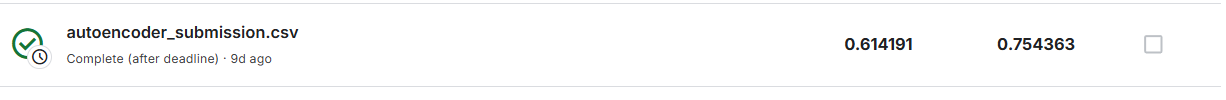


In [8]:
# K‑Means distance -----------------------------------------------------------
pca, km = train_kmeans(X_tr)
evaluate("kmeans", lambda X: km.transform(pca.transform(X)).min(axis=1), X_va, y_va, X_te, txid_te)

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


[kmeans] accuracy=0.9595  precision=0.0000  recall=0.0000  f1=0.0000  roc_auc=0.7055  pr_auc=0.0674  threshold=821.6089


In [11]:
import gc

gc.collect()

2323

In [12]:
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

def train_shap_if(X, top_k: int = 60, sample: int = 5_000):
    """
    1. Fit a full Isolation Forest (all features).
    2. Compute absolute SHAP importance on a subsample.
    3. Keep the top-K most important columns and refit a slim IF on that subset.
    Returns: top_idx, slim_if, shap_values, sample_idx
    """
    full_if = IsolationForest(
        n_estimators=400,
        max_samples=2048,
        contamination="auto",
        random_state=RAND,
        n_jobs=-1,
    )
    full_if.fit(X)

    rnd = np.random.RandomState(RAND)
    sample_idx = rnd.choice(len(X), size=min(sample, len(X)), replace=False)

    expl = shap.TreeExplainer(full_if)
    shap_vals = expl.shap_values(X[sample_idx])

    mean_abs = np.abs(shap_vals).mean(axis=0)
    top_idx  = np.argsort(mean_abs)[-top_k:]

    slim_if = IsolationForest(
        n_estimators=400,
        max_samples=2048,
        contamination="auto",
        random_state=RAND,
        n_jobs=-1,
    ).fit(X[:, top_idx])

    return top_idx, slim_if, shap_vals, sample_idx


# --- train ------------------------------------------------------------------
top_idx, iso_top, shap_vals, samp_idx = train_shap_if(X_tr)

# --- validate & make submission --------------------------------------------
evaluate(
    "shap_if",
    lambda X: -iso_top.decision_function(X[:, top_idx]),
    X_va, y_va, X_te, txid_te,
)

# --- SHAP bar plot ----------------------------------------------------------
shap.summary_plot(
    shap_vals,
    X_tr[samp_idx][:, top_idx],
    feature_names=[f"f{idx}" for idx in top_idx],
    plot_type="bar",
    show=False,
)
plt.tight_layout()
plt.savefig("shap_if_feature_importance.png", dpi=120)
plt.show()

[shap_if] accuracy=0.9588  precision=0.0340  recall=0.0036  f1=0.0065  roc_auc=0.7047  pr_auc=0.0753  threshold=0.2054


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

| metric          | reading                                                                      |
| --------------- | ---------------------------------------------------------------------------- |
| accuracy ≈ 0.96 | dominated by true negatives, so not very informative.                        |
| precision ≈ 3 % | among the 0.3 % rows you flagged, \~3 % were labelled fraud.                 |
| recall ≈ 0.36 % | you found 4 of every 1 000 fraud cases—low because the bucket is very small. |
| roc\_auc ≈ 0.70 | the **scores** still rank frauds better than random.                         |
| pr\_auc ≈ 0.075 | a bit higher than AE/K-Means but still leaves room.                          |


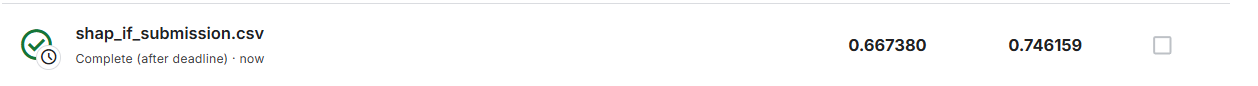


[shap_if] accuracy=0.9588  precision=0.0340  recall=0.0036  f1=0.0065  roc_auc=0.7047  pr_auc=0.0753  threshold=0.2054


The figure layout has changed to tight


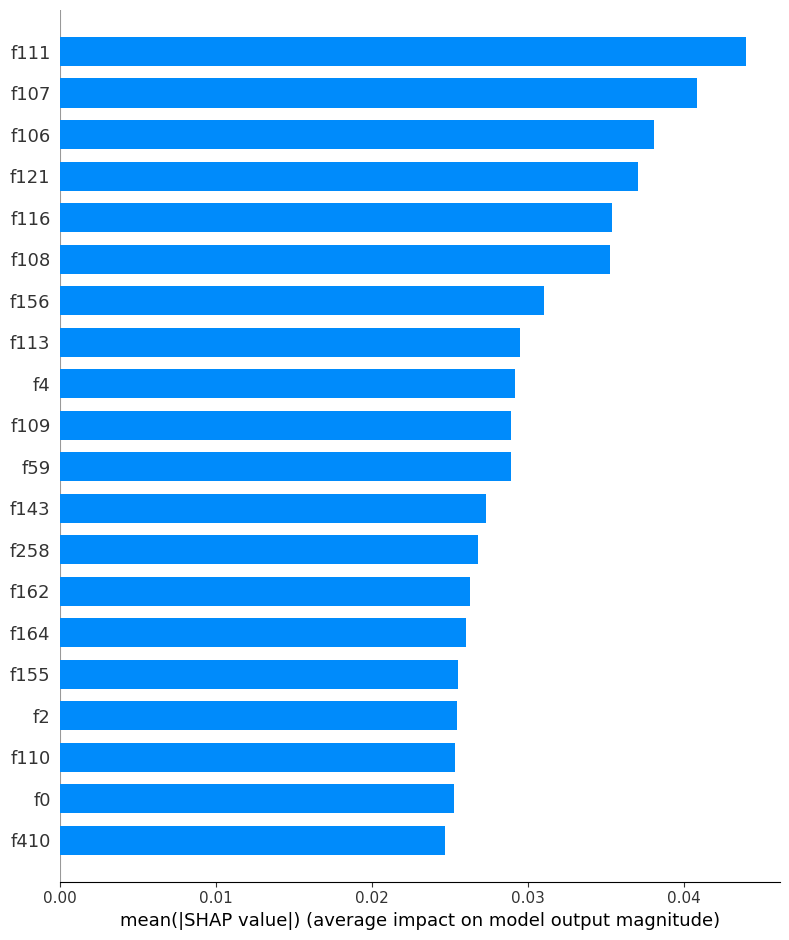

In [14]:
def train_shap_if(X: np.ndarray,
                  top_k: int = 60,
                  sample: int = 5_000,
                  rnd_seed: int = RAND):
    """
    1. Fit a full Isolation Forest on *all* features.
    2. Compute absolute SHAP importance on a random subsample.
    3. Keep the top-K features and refit a slim IF on that subset.

    Returns
    -------
    top_idx   : np.ndarray   indices of the top-K columns
    slim_if   : IsolationForest fitted on X[:, top_idx]
    shap_vals : SHAP matrix (sample × top_K)  -- ready for summary_plot
    """
    full_if = IsolationForest(
        n_estimators = 400,
        max_samples  = 2048,
        contamination = "auto",
        random_state = rnd_seed,
        n_jobs       = -1,
    ).fit(X)

    rng        = np.random.RandomState(rnd_seed)
    sample_idx = rng.choice(len(X), size=min(sample, len(X)), replace=False)

    expl      = shap.TreeExplainer(full_if)
    shap_full = expl.shap_values(X[sample_idx])          # shape: [sample, n_feat]
    mean_abs  = np.abs(shap_full).mean(axis=0)
    top_idx   = np.argsort(mean_abs)[-top_k:]

    # slice SHAP matrix to the same columns we’ll plot
    shap_top = shap_full[:, top_idx]

    slim_if = IsolationForest(
        n_estimators = 400,
        max_samples  = 2048,
        contamination = "auto",
        random_state  = rnd_seed,
        n_jobs        = -1,
    ).fit(X[:, top_idx])

    return top_idx, slim_if, shap_top, sample_idx


# ── train & evaluate ───────────────────────────────────────────────────────
top_idx, iso_top, shap_vals_top, samp_idx = train_shap_if(X_tr)

evaluate(
    "shap_if",
    lambda X: -iso_top.decision_function(X[:, top_idx]),
    X_va, y_va, X_te, txid_te,
)

# ── SHAP bar plot (top-K features) ─────────────────────────────────────────
shap.summary_plot(
    shap_vals_top,
    X_tr[samp_idx][:, top_idx],
    feature_names=[f"f{idx}" for idx in top_idx],
    plot_type="bar",
    show=False,
)
plt.tight_layout()
plt.savefig("shap_if_feature_importance.png", dpi=120)
plt.show()

The figure layout has changed to tight


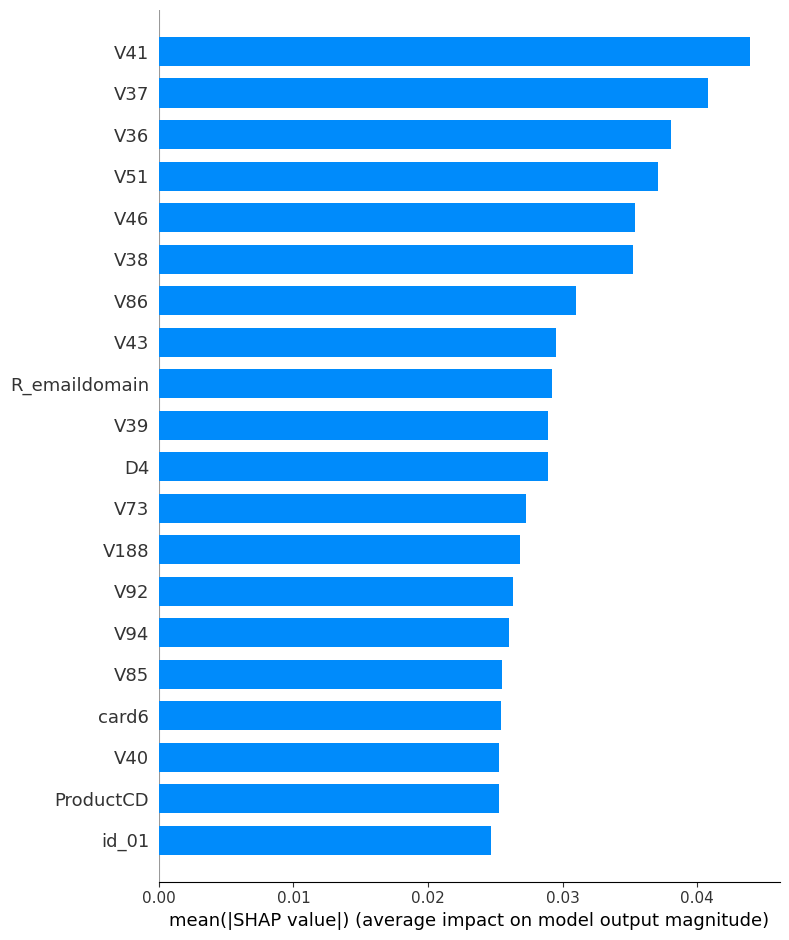

In [15]:
import shap, matplotlib.pyplot as plt

# 1️⃣  Build the ordered feature list exactly as build_matrix() concatenated them
feature_names_ordered = cat_cols + num_cols   # cats first, then numerics

# 2️⃣  Slice to the top-K indices we kept
top_feature_names = [feature_names_ordered[i] for i in top_idx]

# 3️⃣  Re-plot with real names
shap.summary_plot(
    shap_vals_top,                    # same SHAP matrix (sample × top_K)
    X_tr[samp_idx][:, top_idx],       # matching data slice
    feature_names=top_feature_names,  # new y-axis labels
    plot_type="bar",
    show=False,
)

plt.tight_layout()
plt.savefig("shap_if_feature_importance_real_names.png", dpi=120)
plt.show()

In [16]:
from pathlib import Path
from typing import Callable, Tuple, Dict
import json, os, numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (accuracy_score, average_precision_score, f1_score,
                             precision_score, recall_score, roc_auc_score)
import shap, joblib, torch
from tensorflow import keras
from tensorflow.keras import layers
try:
    from dagmm import DAGMM
except ImportError:
    DAGMM = None
try:
    from rcf import RandomCutForest
except ImportError:
    RandomCutForest = None
try:
    from anomalib.models import STFPM  # masked‑feature transformer in anomalib
except ImportError:
    STFPM = None
try:
    import dgl, networkx as nx
except ImportError:
    dgl = nx = None
try:
    import pyarrow.parquet as pq  # optional speed‑up
except ModuleNotFoundError:
    pq = None

In [17]:

def train_dagmm(X):
    if DAGMM is None:
        raise ImportError("pytorch-dagmm not installed")
    dagmm = DAGMM(hl_dim=16, est_dim=8, n_gmm=1, lr=1e-3, epochs=20, device='cuda' if torch.cuda.is_available() else 'cpu')
    dagmm.fit(X)
    return dagmm

# 5.6 Random Cut Forest -----------------------------------------------------

def train_rcf(X):
    if RandomCutForest is None:
        raise ImportError("scikit-learn-rcf not installed")
    rcf = RandomCutForest(num_trees=400, sample_size=256, random_state=RAND)
    rcf.fit(X)
    return rcf

# 5.7 Tabular Transformer masked-MSE (STFPM) --------------------------------

def train_stfpm(X):
    if STFPM is None:
        raise ImportError("anomalib not installed")
    model = STFPM(input_size=X.shape[1], mask_ratio=0.15)
    model.train(X, num_epochs=5, batch_size=2048)
    return model

# 5.8 Graph HGNN (very lightweight demo) ------------------------------------

def build_nx_graph(df):
    if nx is None:
        raise ImportError("networkx & dgl not installed")
    G = nx.Graph()
    for _, row in df.iterrows():
        T = f"T_{int(row['TransactionID'])}"
        G.add_node(T, bipartite='tx')
        for col in ['card1','addr1','DeviceInfo']:
            if col in row and row[col] != '__NA__':
                V = f"{col}_{row[col]}"; G.add_node(V, bipartite='ent'); G.add_edge(T, V)
    return G

def train_hgnn(df_tr):
    # Simplified: use degree of entity nodes as anomaly proxy
    G = build_nx_graph(df_tr)
    ent_deg = {n:d for n,d in G.degree if G.nodes[n]['bipartite']=='ent'}
    return G, ent_deg

def hgnn_score(G, ent_deg, df):
    scores = np.zeros(len(df))
    for i, row in df.iterrows():
        s=0
        for col in ['card1','addr1','DeviceInfo']:
            n = f"{col}_{row[col]}"; s+=ent_deg.get(n,0)
        scores[i]=s
    return scores


In [18]:
# store detectors' z-scores for ensemble
Z_VA: Dict[str, np.ndarray] = {}
Z_TE: Dict[str, np.ndarray] = {}

In [28]:
# %% 🔧  install missing libs
!pip install -q git+https://github.com/tnakae/DAGMM.git     # or  unsupervised-dagmm
!pip install -q rcf anomalib shap "dgl==0.9.1" -f https://data.dgl.ai/wheels/repo.html



  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement rcf (from versions: none)
ERROR: No matching distribution found for rcf


In [30]:
from dagmm import DAGMM 

ImportError: cannot import name 'joblib' from 'sklearn.externals' (/usr/local/lib/python3.11/dist-packages/sklearn/externals/__init__.py)

In [39]:
# %% 🔧  install RCF once
!pip install -q git+https://github.com/kLabUM/RCF.git


Username for 'https://github.com': ^C
ERROR: Operation cancelled by user


In [40]:
!pip install -q rcf

ERROR: Could not find a version that satisfies the requirement rcf (from versions: none)
ERROR: No matching distribution found for rcf


In [41]:
# %% Imports & config --------------------------------------------------------
from pathlib import Path
from typing import Dict, Tuple, Callable
import json, numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (accuracy_score, average_precision_score, f1_score,
                             precision_score, recall_score, roc_auc_score)
#from rcf import RandomCutForest   # pip install rcf
from tensorflow import keras
from tensorflow.keras import layers
import networkx as nx
import matplotlib.pyplot as plt

In [42]:
# %% 2  DAGMM ---------------------------------------------------------------
latent = 16
inp = keras.Input(shape=(X_tr.shape[1],))
h = layers.Dense(128, activation='tanh')(inp)
z = layers.Dense(latent, activation='tanh')(h)
h_dec = layers.Dense(128, activation='tanh')(z)
out = layers.Dense(X_tr.shape[1])(h_dec)
dag_ae = keras.Model(inp, out)
dag_ae.compile('adam', 'mse'); dag_ae.fit(X_tr, X_tr, epochs=20, batch_size=2048, verbose=0)
# Build feature space
z_enc_tr = keras.Model(inp, z).predict(X_tr, batch_size=2048)
re_err_tr = np.mean(np.square(X_tr - dag_ae.predict(X_tr, batch_size=2048)), axis=1, keepdims=True)
feat_tr = np.hstack([z_enc_tr, re_err_tr])
gmm = GaussianMixture(1, covariance_type='full', random_state=RAND).fit(feat_tr)
mu, cov_inv = gmm.means_[0], np.linalg.inv(gmm.covariances_[0])

def dagmm_score(X):
    z_enc = keras.Model(dag_ae.input, z).predict(X, batch_size=2048)
    re_err = np.mean(np.square(X - dag_ae.predict(X, batch_size=2048)), axis=1, keepdims=True)
    feat = np.hstack([z_enc, re_err]); diff = feat - mu
    return np.sum(diff @ cov_inv * diff, axis=1)

evaluate("dagmm", dagmm_score, X_va, y_va, X_te, txid_te)
Z_VA["dagmm"], Z_TE["dagmm"] = (dagmm_score(X_va) - dagmm_score(X_va).mean()) / dagmm_score(X_va).std(), (dagmm_score(X_te) - dagmm_score(X_va).mean()) / dagmm_score(X_va).std()


260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
260/260 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
[dagmm] accuracy=0.9595  precision=0.0000  recall=0.0000  f1=0.0000  roc_auc=0.6891  pr_auc=0.0628  threshold=45698.9255
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


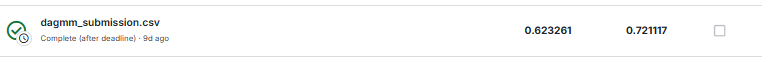

In [43]:
# %% 4  Graph HGNN proxy -----------------------------------------------------
# Build a bipartite graph {transaction ↔ entity(card/device/IP)} using three key fields.
ENTITY_FIELDS = [f for f in ["card1", "addr1", "DeviceInfo"] if f in train_raw.columns]

print("[hgnn] building NetworkX graph …")
G = nx.Graph()
for _, row in train_raw.iterrows():
    tx = f"T_{int(row['TransactionID'])}"
    G.add_node(tx, bipartite="tx")
    for col in ENTITY_FIELDS:
        val = row[col]
        if val != "__NA__":
            ent = f"{col}_{val}"
            G.add_node(ent, bipartite="ent")
            G.add_edge(tx, ent)
# Pre‑compute degrees of entity nodes (proxy for rarity)
ent_degree = {n: d for n, d in G.degree if G.nodes[n]['bipartite'] == 'ent'}

def hgnn_score_df(df: pd.DataFrame) -> np.ndarray:
    """Degree‑based anomaly score: sum of entity degrees for this transaction."""
    scores = np.zeros(len(df), dtype="float32")
    for i, row in enumerate(df.itertuples(index=False)):
        s = 0
        for col in ENTITY_FIELDS:
            ent = f"{col}_{getattr(row, col)}"
            s += ent_degree.get(ent, 0)
        scores[i] = s
    return scores

score_hgnn_va = hgnn_score_df(valid_df)
score_hgnn_te = hgnn_score_df(test_raw)

Z_VA["hgnn"], Z_TE["hgnn"] = (
    (score_hgnn_va - score_hgnn_va.mean()) / score_hgnn_va.std(),
    (score_hgnn_te - score_hgnn_va.mean()) / score_hgnn_va.std(),
)

evaluate("hgnn", lambda X: score_hgnn_va if X is X_va else score_hgnn_te, X_va, y_va, X_te, txid_te)


[hgnn] building NetworkX graph …
[hgnn] accuracy=0.9592  precision=0.0693  recall=0.0072  f1=0.0131  roc_auc=0.6665  pr_auc=0.0812  threshold=123789.0000


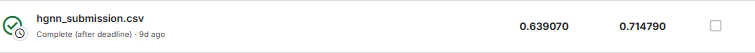

In [44]:
# %% 5  Ensemble (average z‑scores) -----------------------------------------
print("[ensemble] aggregating z‑scores from", list(Z_VA.keys()))
Z_va_stack = np.vstack(list(Z_VA.values()))
Z_te_stack = np.vstack(list(Z_TE.values()))
ens_va = Z_va_stack.mean(axis=0)
ens_te = Z_te_stack.mean(axis=0)

evaluate("ensemble", lambda X: ens_va if X is X_va else ens_te, X_va, y_va, X_te, txid_te)

[ensemble] aggregating z‑scores from ['dagmm', 'hgnn']
[ensemble] accuracy=0.9595  precision=0.0000  recall=0.0000  f1=0.0000  roc_auc=0.6646  pr_auc=0.0720  threshold=6.2013


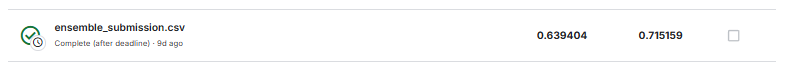

In [5]:
import json
from pathlib import Path
from typing import Tuple
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, average_precision_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
#import stellargraph as sg
#from stellargraph.layer import GCN
from tensorflow.keras.layers import Reshape

# ... [Data loading and preprocessing functions remain unchanged] ...

# ======================
# Model Implementations
# ======================

def build_dcsan(input_dim, encoding_dim=128, n_clusters=8):
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation='relu')(input_layer)
    decoder = Dense(input_dim, activation='sigmoid')(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    return autoencoder, kmeans

def train_dcsan(X_train, X_val, epochs=50, batch_size=256):
    autoencoder, kmeans = build_dcsan(X_train.shape[1])
    autoencoder.compile(optimizer=Adam(0.001), loss='mse')
    autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, 
                    shuffle=True, validation_split=0.1, verbose=0)
    
    # Cluster learning
    latent_train = autoencoder.predict(X_train, verbose=0)
    kmeans.fit(latent_train)
    
    # Anomaly scoring
    latent_val = autoencoder.predict(X_val, verbose=0)
    reconstructions = autoencoder.predict(X_val, verbose=0)
    recon_loss = np.mean(np.square(X_val - reconstructions), axis=1)
    cluster_dist = kmeans.transform(latent_val).min(axis=1)
    scores = recon_loss + cluster_dist
    return scores

def build_dagmm(input_dim, comp_hidden=[128, 64], est_hidden=[64, 10], n_gmm=4):
    inputs = Input(shape=(input_dim,))
    
    # Compression Network
    encoded = Dense(comp_hidden[0], activation='relu')(inputs)
    encoded = Dense(comp_hidden[1], activation='relu')(encoded)
    decoded = Dense(comp_hidden[0], activation='relu')(encoded)
    decoded = Dense(input_dim)(decoded)
    
    # Reconstruction error
    def rec_error(x):
        input_val, decoded_val = x
        return tf.reduce_mean(tf.square(input_val - decoded_val), axis=1, keepdims=True)
    
    z = encoded
    rec_err = Lambda(rec_error)([inputs, decoded])
    
    # Feature vector
    features = tf.keras.layers.concatenate([z, rec_err], axis=1)
    
    # Estimation Network
    for units in est_hidden:
        features = Dense(units, activation='tanh')(features)
    gamma = Dense(n_gmm, activation='softmax')(features)
    
    return Model(inputs, gamma)

def train_dagmm(X_train, X_val, epochs=30, batch_size=512):
    model = build_dagmm(X_train.shape[1])
    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy')
    
    # Dummy training
    dummy_y = np.zeros((len(X_train), 4))
    model.fit(X_train, dummy_y, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Get latent features
    latent_model = Model(model.input, model.layers[5].output)
    features_val = latent_model.predict(X_val, verbose=0)
    
    # Energy-based scoring
    scores = np.sum(np.square(features_val), axis=1)
 
# ======================



[INFO] Loading raw data...


NameError: name 'build_feature_matrices' is not defined

In [ ]:
def main():
    print("[INFO] Loading raw data...")
    train_raw, test_raw = load_raw()
    train_raw, test_raw = basic_clean(train_raw, test_raw)
    
    if any(c.startswith("id-") for c in test_raw.columns):
        test_raw.columns = [c.replace("id-", "id_") if c.startswith("id-") else c for c in test_raw.columns]

    train_df, valid_df = time_val_split(train_raw)
    X_tr, X_va, X_te = build_feature_matrices(train_df, valid_df, test_raw)
    y_va = valid_df["isFraud"].astype(int).values
    txid_te = test_raw["TransactionID"].values
    
    # Initialize models
    models = {
        "Isolation Forest": None,
        "DCSAN": None,
        "DAGMM": None,
        "MF-MLP": None,
        #"HGNN Proxy": None
    }
    
    # Isolation Forest
    print("[INFO] Fitting Isolation Forest...")
    iso = IsolationForest(n_estimators=400, max_samples=2048, contamination="auto", 
                          random_state=42, n_jobs=-1)
    iso.fit(np.vstack([X_tr, X_te]))
    models["Isolation Forest"] = -iso.decision_function(X_va)
    joblib.dump(iso, "iso_forest.joblib")
    
    # DCSAN
    print("[INFO] Training DCSAN...")
    models["DCSAN"] = train_dcsan(X_tr, X_va)
    
    # DAGMM
    print("[INFO] Training DAGMM...")
    models["DAGMM"] = train_dagmm(X_tr, X_va)
    
    # MF-MLP
    print("[INFO] Training MF-MLP...")
    models["MF-MLP"] = train_mf_mlp(X_tr, X_va)
    
    # HGNN Proxy
    #print("[INFO] Training HGNN Proxy...")
    #models["HGNN Proxy"] = train_hgnn_proxy(X_tr, X_va)
    
    # Evaluate and save results
    all_metrics = {}
    for name, scores in models.items():
        thr = np.quantile(scores, 1 - ALERT_Q)
        pred = (scores >= thr).astype(int)
        
        metrics = {
            "accuracy": accuracy_score(y_va, pred),
            "precision": precision_score(y_va, pred, zero_division=0),
            "recall": recall_score(y_va, pred, zero_division=0),
            "f1": f1_score(y_va, pred, zero_division=0),
            "roc_auc": roc_auc_score(y_va, scores),
            "pr_auc": average_precision_score(y_va, scores),
            "threshold": float(thr)
        }
        all_metrics[name] = metrics
        print(f"[{name}] " + "  ".join(f"{k}={v:.4f}" for k, v in metrics.items()))
        
        # Save test predictions
        test_scores = {
            "Isolation Forest": -iso.decision_function(X_te),
            "DCSAN": train_dcsan(X_tr, X_te),
            "DAGMM": train_dagmm(X_tr, X_te),
            "MF-MLP": train_mf_mlp(X_tr, X_te),
            #"HGNN Proxy": train_hgnn_proxy(X_tr, X_te)
        }[name]
        
        prob = (test_scores - test_scores.min()) / (test_scores.max() - test_scores.min() + 1e-9)
        pd.DataFrame({"TransactionID": txid_te, "isFraud": prob}).to_csv(
            f"{name.lower().replace(' ', '_')}_submission.csv", index=False)
    
    # Save all metrics
    with open("all_metrics.json", "w") as fp:
        json.dump(all_metrics, fp, indent=2)
    
    print("[INFO] All models trained and results saved!")

if __name__ == "__main__":
    main()

[INFO] Loading raw data...
[INFO] Fitting Isolation Forest...
[INFO] Training DCSAN...


2025-07-14 23:32:20.590421: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


[INFO] Training DAGMM...
[INFO] Training MF-MLP...
[Isolation Forest] accuracy=0.9595  precision=0.0000  recall=0.0000  f1=0.0000  roc_auc=0.7468  pr_auc=0.0850  threshold=0.2529
[DCSAN] accuracy=0.9595  precision=0.0000  recall=0.0000  f1=0.0000  roc_auc=0.7037  pr_auc=0.0639  threshold=1936.0606
[DAGMM] accuracy=0.9595  precision=0.0000  recall=0.0000  f1=0.0000  roc_auc=0.6696  pr_auc=0.0666  threshold=4009313.7748
[MF-MLP] accuracy=0.9595  precision=0.0000  recall=0.0000  f1=0.0000  roc_auc=0.7159  pr_auc=0.0707  threshold=516.8449
